In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Download dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 26369341.41it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Train classical network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [37]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.238
[1,  4000] loss: 2.067
[1,  6000] loss: 1.953
[1,  8000] loss: 1.878
[1, 10000] loss: 1.779
[1, 12000] loss: 1.716
[1, 14000] loss: 1.667
[1, 16000] loss: 1.641
[1, 18000] loss: 1.602
[1, 20000] loss: 1.559
[1, 22000] loss: 1.539
[1, 24000] loss: 1.504
[1, 26000] loss: 1.481
[1, 28000] loss: 1.464
[1, 30000] loss: 1.426
[1, 32000] loss: 1.369
[1, 34000] loss: 1.384
[1, 36000] loss: 1.333
[1, 38000] loss: 1.326
[1, 40000] loss: 1.337
[1, 42000] loss: 1.289
[1, 44000] loss: 1.314
[1, 46000] loss: 1.299
[1, 48000] loss: 1.255
[1, 50000] loss: 1.232
[2,  2000] loss: 1.203
[2,  4000] loss: 1.141
[2,  6000] loss: 1.177
[2,  8000] loss: 1.155
[2, 10000] loss: 1.148
[2, 12000] loss: 1.097
[2, 14000] loss: 1.126
[2, 16000] loss: 1.125
[2, 18000] loss: 1.095
[2, 20000] loss: 1.070
[2, 22000] loss: 1.054
[2, 24000] loss: 1.079
[2, 26000] loss: 1.056
[2, 28000] loss: 1.087
[2, 30000] loss: 1.041
[2, 32000] loss: 1.033
[2, 34000] loss: 1.025
[2, 36000] loss: 0.976
[2, 38000] 

In [38]:
#Whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [9]:
torch.save(net, 'net.pth')

NameError: ignored

In [0]:
net = torch.load('net.pth')

# PGD implementation

In [0]:
def pgd_attack(model, image, label, eps=0.001, step=0.001, iters=50) :
    loss_fn = nn.CrossEntropyLoss()
        
    ori_image = image.data
        
    for i in range(iters) :    
        image.requires_grad = True
        predicted = model(image)

        model.zero_grad()
        loss = loss_fn(predicted, label)
        loss.backward()

        #Gradient calculation
        adv_image = image + step*image.grad.sign()

        # Project back into l_norm ball and correct range
        eta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + eta, min=0, max=1).detach_()
            
    return image

Test one image

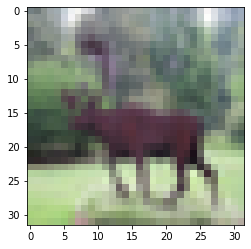

  d e e r


In [50]:
# get random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show orginal image
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels]))

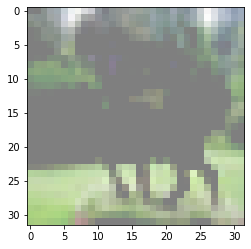

  d e e r


In [72]:
# Show Attack image
images_adv = pgd_attack(net, images, labels)
imshow(torchvision.utils.make_grid(images_adv))
outputs = net(images_adv) #Label calculation
_, predicted = torch.max(outputs.data, 1) #killer
print(' '.join('%5s' % classes[predicted]))

# Train adversial network

In [17]:
correct = 0
total = 0

for images, labels in testloader:
    
    images = pgd_attack(net, images, labels)
    labels = labels
    outputs = net(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 11.000000 %
